In [358]:
import numpy as np
from matplotlib import pyplot as plt
import itertools

In [359]:
bullseye = np.load('bullseye.npy')
flag = np.load('flag.npy')
spiral = np.load('spiral.npy')
small = np.load('small.npy')

### Problem 1.1

In [35]:
def get_edge_dict(img):
    edge_dict = dict()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            edge_dict[(i, j)] = []
            if i == 0 and j == 0:
                edge_dict[(i, j)].append(np.array([i+1, j]))
                edge_dict[(i, j)].append(np.array([i, j+1]))
            elif i == img.shape[0]-1 and j == 0:
                edge_dict[(i, j)].append(np.array([i, j+1]))
                edge_dict[(i, j)].append(np.array([i-1, j]))
            elif i == 0 and j == img.shape[1]-1:
                edge_dict[(i, j)].append(np.array([i+1, j]))
                edge_dict[(i, j)].append(np.array([i, j-1]))
            elif i == img.shape[0]-1 and j == img.shape[1]-1:
                edge_dict[(i, j)].append(np.array([i-1, j]))
                edge_dict[(i, j)].append(np.array([i, j-1]))
            elif i == 0:
                edge_dict[(i, j)].append(np.array([i+1, j]))
                edge_dict[(i, j)].append(np.array([i, j+1]))
                edge_dict[(i, j)].append(np.array([i, j-1]))
            elif j == 0:
                edge_dict[(i, j)].append(np.array([i+1, j]))
                edge_dict[(i, j)].append(np.array([i, j+1]))
                edge_dict[(i, j)].append(np.array([i-1, j]))
            elif i == img.shape[0]-1:
                edge_dict[(i, j)].append(np.array([i, j+1]))
                edge_dict[(i, j)].append(np.array([i-1, j]))
                edge_dict[(i, j)].append(np.array([i, j-1]))
            elif j == img.shape[1]-1:
                edge_dict[(i, j)].append(np.array([i+1, j]))
                edge_dict[(i, j)].append(np.array([i-1, j]))
                edge_dict[(i, j)].append(np.array([i, j-1]))
            else:
                edge_dict[(i, j)].append(np.array([i+1, j]))
                edge_dict[(i, j)].append(np.array([i, j+1]))
                edge_dict[(i, j)].append(np.array([i-1, j]))
                edge_dict[(i, j)].append(np.array([i, j-1]))        
    
    return edge_dict

In [159]:
def img_conversion(img):
    img_matrix = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(img[i, j] == np.array([0, 1, 0])) == 3:
                img_matrix[i, j] = 1
            elif np.sum(img[i, j] == np.array([0, 0, 1])) == 3:
                img_matrix[i, j] = 2
                
    return img_matrix

In [231]:
def global_score(possibility, img):
    img = img_conversion(img)
    edges = get_edge_dict(img)
    score = 0
    possibility = np.array(possibility).reshape(img.shape[0], img.shape[1])
    for i in range(possibility.shape[0]):
        for j in range(possibility.shape[1]):
            if possibility[i, j] == img[i, j]:
                score += 10
                
            for neighbor in edges[(i, j)]:
                if possibility[i, j] == possibility[neighbor[0], neighbor[1]]:
                    score += 10 * 0.5
                elif np.abs(possibility[i, j] - possibility[neighbor[0], neighbor[1]]) == 1:
                    score += 2 * 0.5
                    
    return score

In [230]:
def partition_score(img):
    all_possibilities = itertools.product([0, 1], repeat = img.shape[0] * img.shape[1])
    score = 0
    for i in all_possibilities:
        score += np.exp(global_score(i, img))
        
    return score

In [229]:
def get_marginal(coordinate, img, color):
    partition = partition_score(img)
    all_possibilities = itertools.product([0, 1], repeat = 9)
    score = 0.0
    for i in all_possibilities:
        possibility = np.array(i).reshape(img.shape[0], img.shape[1])
        if possibility[coordinate[0], coordinate[1]] == color:
            score += np.exp(global_score(i, img))
            
    return score/partition

In [232]:
marginals_matrix_red = np.zeros((small.shape[0], small.shape[1]))
marginals_matrix_green = np.zeros((small.shape[0], small.shape[1]))

for i in range(small.shape[0]):
    for j in range(small.shape[1]):
        marginals_matrix_red[i, j] = get_marginal([i, j], small, 0)
        marginals_matrix_green[i, j] = get_marginal([i, j], small, 1)
        
print(marginals_matrix_red)
print()
print(marginals_matrix_green)

[[ 1.          1.          1.        ]
 [ 0.99999998  1.          0.99999998]
 [ 0.00252378  0.00248464  0.00252378]]

[[  5.79905571e-12   1.95516261e-15   5.79905571e-12]
 [  1.51930154e-08   6.56942344e-12   1.51930154e-08]
 [  9.97476218e-01   9.97515359e-01   9.97476218e-01]]


### Problem 1.3

In [354]:
def denoise(img, num_epochs):
    edges = get_edge_dict(img)
    q_matrix = torch.DoubleTensor(img.shape[0], img.shape[1], 3).uniform_(0, 1).numpy()

    for epoch in range(num_epochs):
        print(epoch, end = ' ')
        q = img * 10
        q2 = np.zeros((img.shape[0], img.shape[1], num_colors))
        for i in range(q_matrix.shape[0]):
            for j in range(q_matrix.shape[1]):
                for k in range(q_matrix.shape[2]):
                    for l in edges[(i, j)]:
                        for m in range(q_matrix.shape[2]):
                            if m == k:
                                q[i,j,k] += q_matrix[l[0], l[1], m] * 10
                            elif np.abs(m - k) == 1:
                                q[i,j,k] += q_matrix[l[0], l[1], m] * 2

                for p in range(q_matrix.shape[2]):
                    q2[i,j,p] = np.exp(q[i,j,p])/np.sum(np.exp(q[i,j]))
                    
        q_matrix = q2
    
    return q_matrix

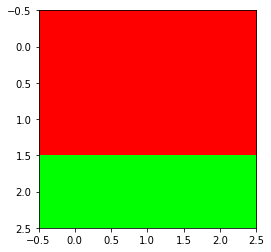

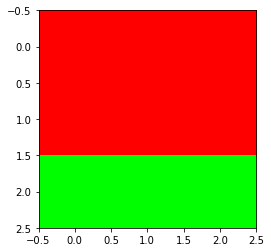

In [342]:
small_denoised = denoise(small, 30, 3)
plt.imshow(small)
plt.show()
plt.imshow(small_denoised)
plt.show()

In [343]:
print(small_denoised[:, :, 0])
print()
print(small_denoised[:, :, 1])

[[  1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  9.99999985e-01   1.00000000e+00   9.99999985e-01]
 [  4.53978686e-05   1.52521210e-08   4.53978686e-05]]

[[  5.10909027e-12   1.71390843e-15   5.10909027e-12]
 [  1.52189208e-08   5.10909027e-12   1.52189208e-08]
 [  9.99954600e-01   9.99999985e-01   9.99954600e-01]]


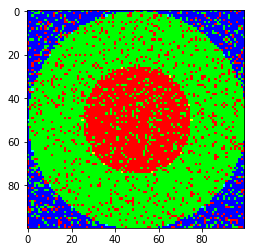

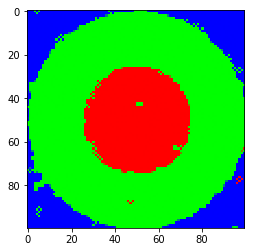

In [353]:
bullseye_denoised = denoise(bullseye, 100, 3)
plt.imshow(bullseye)
plt.show()
plt.imshow(bullseye_denoised)
plt.show()

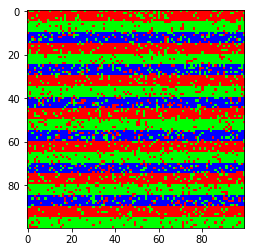

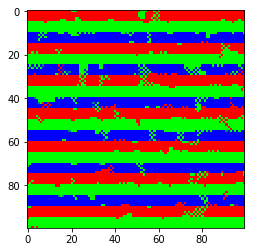

In [350]:
flag_denoised = denoise(flag, 100, 3)
plt.imshow(flag)
plt.show()
plt.imshow(flag_denoised)
plt.show()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

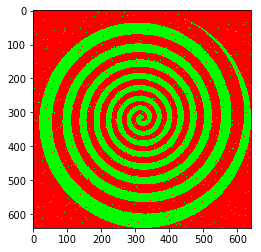

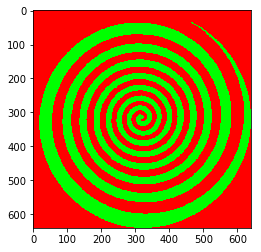

In [357]:
spiral_denoised = denoise(spiral, 30, 3)
plt.imshow(spiral)
plt.show()
plt.imshow(spiral_denoised)
plt.show()